# DIGI405 Lab Class 9: Text classification 2

*Thanks to Phil Davies for his great work adding new functionality to this notebook and his contributions to last week's notebook.*

What can text classification techniques tell us about sentiment or tone? Can text classification help us find distinguishing features between two groups of texts?  

This notebook introduces you to:

1. A new data-set relevant to sentiment classification.  
2. Feature selection using [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)
3. Automating parameter tuning using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

**Remember:** Each time you change settings below, you will need to rerun the cells that create the pipeline and does the classification.

<div style="border:1px solid black;margin-top:1em;padding:0.5em;">
    <strong>Task:</strong> Throughout the notebook there are defined tasks for you to do. Watch out for them - they will have a box around them like this! Make sure you take some notes as you go.
</div>

## Setup

Below we are importing required libraries. We will be using [scikit-learn](https://scikit-learn.org) for text classification in DIGI405. We will use the Naive Bayes Classifier. Scikit-learn has different feature extraction methods based on counts or tf-idf weights. We will also use NLTK for pre-processing.

In [1]:
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.datasets import fetch_20newsgroups

import matplotlib.pyplot as plt

import re

import nltk
from nltk import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
from nltk.stem import SnowballStemmer 
from nltk.stem import PorterStemmer 
from nltk.corpus import wordnet

# The following added to the Lab9 code.
from nltk.corpus import movie_reviews

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
import numpy as np #note last week's lab used 'import numpy'
import pandas as pd
import random

Run this to make sure you have the stop word list and other data for pre-processing.

This cell will also download one of the data-sets that comes pre-packaged with NLTK: a data-set of movie reviews. There is more information on this below. 

In [2]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('movie_reviews')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/allyhassell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/allyhassell/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/allyhassell/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/allyhassell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/allyhassell/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


True

This cell loads some defaults for the stop word lists.

In [3]:
stop_words = None
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words
nltk_stop_words = nltk.corpus.stopwords.words('english')

Define some functions ...

In [5]:
# nice preview of document
def get_preview(docs, targets, target_names, doc_id, max_len=0):
    preview = ''
    if max_len < 1:
        preview += 'Label\n'
        preview += '=====\n'
    else:
        preview += str(doc_id)
        preview += '\t'
    if isinstance(targets[doc_id], str):
        preview += targets[doc_id]
    else:
        preview += target_names[targets[doc_id]]
    if max_len < 1:
        preview += '\n\nFull Text\n'
        preview += '=========\n'
        preview += docs[doc_id]
        preview += '\n'
    else:
        excerpt = get_excerpt(docs[doc_id], max_len)
        preview += '\t' + excerpt
    return preview

_RE_COMBINE_WHITESPACE = re.compile(r"\s+")

# generate an excerpt
def get_excerpt(text, max_len):
    excerpt = _RE_COMBINE_WHITESPACE.sub(' ',text[0:max_len])
    if max_len < len(text):
        excerpt += '...'
    return excerpt.strip()

# combine a defined stop word list (or no stop word list) with any extra stop words defined
def set_stop_words(stop_word_list, extra_stop_words):
    if len(extra_stop_words) > 0:
        if stop_word_list is None:
            stop_word_list = []
        stop_words = list(stop_word_list) + extra_stop_words
    else:
        stop_words = stop_word_list
        
    return stop_words

# initiate stemming or lemmatising
def set_normaliser(normalise):
    if normalise == 'PorterStemmer':
        normaliser = PorterStemmer()
    elif normalise == 'SnowballStemmer':
        normaliser = SnowballStemmer('english')
    elif normalise == 'WordNetLemmatizer':
        normaliser = WordNetLemmatizer()
    else:
        normaliser = None
    return normaliser

# we are using a custom tokenisation process to allow different tokenisers and stemming/lemmatising ...
def tokenise(doc):
    global tokeniser, normalise, normaliser
    
    # you could obviously add more tokenisers here if you wanted ...
    if tokeniser == 'sklearn':
        tokenizer = RegexpTokenizer(r"(?u)\b\w\w+\b") # this is copied straight from sklearn source
        tokens = tokenizer.tokenize(doc)
    elif tokeniser == 'word_tokenize':
        tokens = word_tokenize(doc)
    elif tokeniser == 'wordpunct':
        tokens = wordpunct_tokenize(doc)
    elif tokeniser == 'nopunct':
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(doc)
    else:
        tokens = word_tokenize(doc)
        
    # if using a normaliser then iterate through tokens and return the normalised tokens ...
    if normalise == 'PorterStemmer':
        return [normaliser.stem(t) for t in tokens]
    elif normalise == 'SnowballStemmer':
        return [normaliser.stem(t) for t in tokens]
    elif normalise == 'WordNetLemmatizer':
        # NLTK's lemmatiser needs parts of speech, otherwise assumes everything is a noun
        pos_tokens = nltk.pos_tag(tokens)
        lemmatised_tokens = []
        for token in pos_tokens:
            # NLTK's lemmatiser needs specific values for pos tags - this rewrites them ...
            # default to noun
            tag = wordnet.NOUN
            if token[1].startswith('J'):
                tag = wordnet.ADJ
            elif token[1].startswith('V'):
                tag = wordnet.VERB
            elif token[1].startswith('R'):
                tag = wordnet.ADV
            lemmatised_tokens.append(normaliser.lemmatize(token[0],tag))
        return lemmatised_tokens
    else:
        # no normaliser so just return tokens
        return tokens

# CountVectorizer pre-processor - remove numerics.
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text


## Load corpus and set train/test split

Today we will work with a movies reviews data-set. The reviews are annotated with sentiment polarities "pos" and "neg". You can get more information on the data-set and download it from [NLTK's data-set page](http://www.nltk.org/nltk_data/) and the [movie reviews data page](https://www.cs.cornell.edu/people/pabo/movie-review-data/)).

This cell also sets the train/test split. 80% of the data is used for training and 20% is used for testing. The documents are assigned to each group randomly. It can be useful to rerun this cell to reshuffle your dataset so you can evaluate your model using different data for training and testing.

In [6]:
# define list of class names.
dataset_target_names = ['neg', 'pos']

# assign the train/test split - 0.2 is 80% for training, 20% for testing
test_size = 0.2

#
dataset_data = [(movie_reviews.raw(fileid))
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]
dataset_target = [category
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

# do the train test split ...
# docs_train and docs_test are the documents
# y_train and y_test are the labels
docs_train, docs_test, y_train, y_test = train_test_split(dataset_data, 
                                                          dataset_target, 
                                                          test_size = test_size, 
                                                          random_state=None)

## Inspect documents and labels

In the next cells we can look at the data we have imported. Firstly, we will preview the document labels and a brief excerpt.

In [7]:
for train_id in range(len(docs_train)):
    print(get_preview(docs_train, y_train, dataset_target_names, train_id, max_len=80))

0	neg	for better or worse , the appearance of basic instinct in the movie marketplace ...
1	neg	synopsis : lifelong friends rafe ( affleck ) and danny ( hartnett ) join the us ...
2	pos	" a breed apart " casts rutger hauer as a crazy , bird-loving recluse who picks...
3	pos	one of kyle mclachlan's earlier cinematic features , this movie has had an obvio...
4	pos	ladies and gentlemen , 1997's independence day is here ! it's title : starship ...
5	pos	three things i learned from " being john malkovich " : when getting on the eleva...
6	neg	this is the first film in what would become the most successful series of horror...
7	pos	in tim burton's `sleepy hollow' , there is a mysterious headless horseman who de...
8	neg	well , what are you going to expect ? it's a movie about a big snake that eats ...
9	pos	most sequels don't do what they're supposed to do like " toy story 2 " does . f...
10	pos	" say , any of you know how to madison ? " --- brad " asshole " majors ( barry...
11	pos	in 1977 

You can use this cell to inspect a specific document and its label based on its index in the training set. Note: The indexes will change each time you import the data above because of the random train/test split.

<div style="border:1px solid black;margin-top:1em;padding:0.5em;">
    <strong>Task 1:</strong> Inspect some off the documents in each class and think about the kinds of words that might be useful features in this text classification task.
</div>

In [10]:
train_id = 14
print(get_preview(docs_train, y_train, dataset_target_names, train_id))

Label
=====
pos

Full Text
 ( warning to those who have not seen seven : this review contains some spoiler information . ) 
seven is a powerful , fully-realized film on the level of the silence of the lambs . 
it is a disturbing film that accomplishes its biggest of goals--it occupies the viewers mind long after the closing credits have rolled . 
while this film is not for the squeamish , there is no denying that seven demands attention , for it is a film that transcends its genre in both style and substance . 
for starters , classifying seven as a " thriller " would not be an altogether complete classification of this film . 
while i was genuinely thrilled throughout , i would rather call seven an " intense drama , " because that is what it delivers--meaningful scenes with a relentlessness that does not readily let up . 
part of director david finchers accomplishment is in style . 
he seems to have a knack for knowing exactly how the average person fears something as " simple " as a c

## Feature extraction / Pre-processing

You can consult last week's notebook for more information on each setting below.

On the first run through, just use these settings.

In [11]:
Vectorizer = CountVectorizer
lowercase = True
tokeniser = 'nopunct' # note a new tokeniser setting has been added called nopunct based on tokenising with the regex \w+
normalise = None
stop_word_list = nltk_stop_words
extra_stop_words = []
min_df = 0.0
max_df = 1.0
max_features = 1000
ngram_range = (1, 1) 
encoding = 'utf-8'
decode_error = 'ignore' # what to do if contains characters not of the given encoding - options 'strict', 'ignore', 'replace'

### New settings for the feature selection step

The feature selection step selects the top features based on [univariate statistical tests](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection). Here we are using [mutual information scores](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif) to assess the dependency between each feature and the class labels. 

The value below sets the number of features to select and use in our classifier. In this case we will start with 100 features, based on the mutual information score.

In [12]:
kbest = 100

## Setup a pipeline: feature extraction → feature selection → classifier

**Important Note 1:** When you change settings above or reload your dataset you should rerun this cell!

**Important Note 2:** This cell outputs the settings you used above, which you can cut and paste into a document to keep track of changes you are making and their effects.

In [13]:
# you shouldn't need to change anything in this cell!

stop_words = set_stop_words(stop_word_list, extra_stop_words)
normaliser = set_normaliser(normalise)

pipeline = Pipeline([
    ('vectorizer', Vectorizer(tokenizer = tokenise,
                              lowercase = lowercase,
                              min_df = min_df, 
                              max_df = max_df, 
                              max_features = max_features,
                              stop_words = stop_words, 
                              ngram_range = ngram_range,
                              encoding = encoding, 
                              preprocessor = preprocess_text,
                              decode_error = decode_error)),
    ('selector', SelectKBest(score_func = mutual_info_classif, k=kbest)),
    ('classifier', MultinomialNB()), #here is where you would specify an alternative classifier
])

print('Classifier settings')
print('===================')
print('classifier:', type(pipeline.steps[2][1]).__name__)
print('selector:', type(pipeline.steps[1][1]).__name__)
print('vectorizer:', type(pipeline.steps[0][1]).__name__)
print('classes:', dataset_target_names)
print('lowercase:', lowercase)
print('tokeniser:', tokeniser)
print('normalise:', normalise)
print('min_df:', min_df)
print('max_df:', max_df)
print('max_features:', max_features)
if stop_word_list == nltk_stop_words:
    print('stop_word_list:', 'nltk_stop_words')
elif stop_word_list == sklearn_stop_words:
    print('stop_word_list:', 'sklearn_stop_words')
else:
    print('stop_word_list:', 'None')
print('extra_stop_words:', extra_stop_words)
print('ngram_range:', ngram_range)
print('encoding:', encoding)
print('decode_error:', decode_error)
print('kbest:', kbest)

Classifier settings
classifier: MultinomialNB
selector: SelectKBest
vectorizer: CountVectorizer
classes: ['neg', 'pos']
lowercase: True
tokeniser: nopunct
normalise: None
min_df: 0.0
max_df: 1.0
max_features: 1000
stop_word_list: nltk_stop_words
extra_stop_words: []
ngram_range: (1, 1)
encoding: utf-8
decode_error: ignore
kbest: 100


## Train the classifier and predict labels on test data

Because we are adding the feature selection step, the classifier will be slower as it has to calculate MI scores for each feature and rank them. This will increase the more features you extract.

**Important Note:** You can cut and paste the model output into a document (with the settings above) to keep track of changes you are making and their effects.

Evaluation metrics
              precision    recall  f1-score   support

         neg       0.81      0.78      0.79       202
         pos       0.78      0.81      0.80       198

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.79       400
weighted avg       0.80      0.80      0.79       400



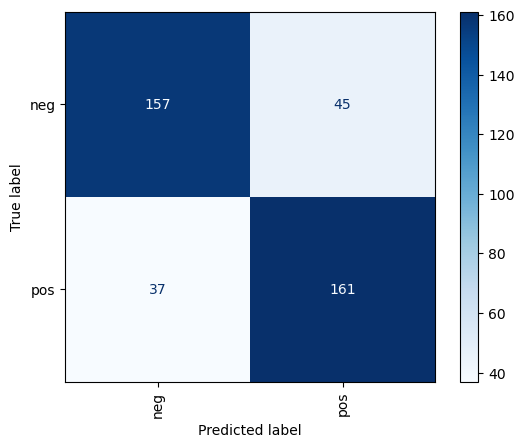

In [14]:
# you shouldn't need to change anything in this cell!

pipeline.fit(docs_train, y_train)
y_predicted = pipeline.predict(docs_test)

# print report
print('Evaluation metrics')
print('==================')
print(metrics.classification_report(y_test, y_predicted, target_names = dataset_target_names))
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_predicted, labels=dataset_target_names)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset_target_names)
disp = disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='vertical')
plt.show()

vect = pipeline.steps[0][1]
clf = pipeline.steps[2][1]

logodds=clf.feature_log_prob_[1]-clf.feature_log_prob_[0]
    
lookup = dict((v,k) for k,v in vect.vocabulary_.items())

We will now look at the features ranked by information gain (MI) and by class.

In [15]:
# Get SelectKBest feature scores
features = pipeline.named_steps['selector']
# get top k feature indices
cols = features.get_support(indices=True)
# get corresponding feature scores 
top_k_feature_scores  = [features.scores_[i] for i in cols]

# get vectorizer
featnames = pipeline.named_steps['vectorizer']
# get all feature names
fred = featnames.get_feature_names()
# get corresponding feature names
top_k_feature_names = [fred[i] for i in cols]

names_scores = list(zip(top_k_feature_names, top_k_feature_scores, logodds))
ns_df = pd.DataFrame(data = names_scores, columns=['Feature_names', 'Feature_Scores', 'Log odds'])

#Sort the dataframe for better visualization - change this to reorder by 
print('Top features by information gain')
ns_df_sorted = ns_df.sort_values(['Feature_Scores', 'Log odds', 'Feature_names'], ascending = [False, False, False])
display(ns_df_sorted[0:10])

print('Features most indicative of', dataset_target_names[0])
ns_df_sorted = ns_df.sort_values(['Log odds', 'Feature_Scores', 'Feature_names'], ascending = [True, False, False])
display(ns_df_sorted[0:10])

print('Features most indicative of', dataset_target_names[1])
ns_df_sorted = ns_df.sort_values(['Log odds', 'Feature_Scores', 'Feature_names'], ascending = [False, False, False])
display(ns_df_sorted[0:10])

Top features by information gain


/Users/allyhassell/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Feature_names,Feature_Scores,Log odds
9,bad,0.043487,-1.187383
98,worst,0.031375,-1.916117
13,boring,0.024486,-1.723491
83,stupid,0.024076,-1.636361
40,life,0.023284,0.534888
73,ridiculous,0.020091,-2.014557
59,perfect,0.019009,0.817348
8,awful,0.018597,-1.800487
64,plot,0.017531,-0.602557
85,supposed,0.016991,-1.246400


Features most indicative of neg


,Feature_names,Feature_Scores,Log odds
73,ridiculous,0.020091,-2.014557
98,worst,0.031375,-1.916117
19,dull,0.014679,-1.835905
8,awful,0.018597,-1.800487
93,wasted,0.015085,-1.755863
92,waste,0.016554,-1.735609
13,boring,0.024486,-1.723491
83,stupid,0.024076,-1.636361
87,terrible,0.013046,-1.566060
48,mess,0.015347,-1.506813


Features most indicative of pos


,Feature_names,Feature_Scores,Log odds
37,jackie,0.006505,1.681702
46,memorable,0.014633,1.351095
79,spielberg,0.006545,1.239335
22,excellent,0.012241,1.178438
5,animation,0.007290,1.153927
60,perfectly,0.014137,1.135141
84,subtle,0.009588,1.065516
65,political,0.006827,1.049156
95,wonderful,0.013241,1.016726
20,effective,0.011699,0.981175


## List all features

Just for your reference here is a count and list of all features extracted in the first step of the pipeline.

In [16]:
print('Total Features: ',len(vect.get_feature_names()))
print(vect.get_feature_names())

Total Features:  1000
['ability', 'able', 'absolutely', 'across', 'act', 'acting', 'action', 'actor', 'actors', 'actress', 'actual', 'actually', 'add', 'age', 'agent', 'ago', 'air', 'alien', 'aliens', 'allen', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'amazing', 'america', 'american', 'among', 'amount', 'amusing', 'animated', 'animation', 'annoying', 'another', 'anyone', 'anything', 'anyway', 'apart', 'apparently', 'appear', 'appearance', 'appears', 'approach', 'army', 'around', 'art', 'ask', 'aspect', 'atmosphere', 'attempt', 'attempts', 'attention', 'audience', 'audiences', 'away', 'awful', 'b', 'baby', 'back', 'background', 'bad', 'band', 'based', 'basically', 'batman', 'battle', 'beautiful', 'beauty', 'become', 'becomes', 'begin', 'beginning', 'begins', 'behind', 'believable', 'believe', 'ben', 'best', 'better', 'beyond', 'big', 'biggest', 'bill', 'bit', 'black', 'blood', 'blue', 'bob', 'body', 'bond', 'book', 'boring', 'box', 'boy', 'break', 'brief', 'br

/Users/allyhassell/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


This is a list of all features selected based on information gain.

In [15]:
print('Total Features: ',len(ns_df['Feature_names']))
print(list(ns_df['Feature_names']))

Total Features:  100
['action', 'almost', 'also', 'although', 'always', 'american', 'attempt', 'awful', 'bad', 'beautiful', 'best', 'better', 'boring', 'brilliant', 'cameron', 'classic', 'complex', 'dark', 'death', 'despite', 'different', 'dull', 'effective', 'especially', 'excellent', 'extremely', 'fails', 'family', 'father', 'film', 'films', 'friends', 'gives', 'great', 'guy', 'hilarious', 'history', 'human', 'intelligent', 'jackie', 'job', 'jokes', 'least', 'life', 'like', 'love', 'many', 'may', 'maybe', 'memorable', 'mess', 'minute', 'movie', 'normal', 'nothing', 'often', 'one', 'others', 'overall', 'people', 'perfect', 'perfectly', 'performance', 'performances', 'planet', 'plot', 'political', 'poor', 'powerful', 'project', 'quite', 'realistic', 'reality', 'ridiculous', 'right', 'save', 'script', 'seen', 'small', 'sometimes', 'star', 'story', 'strong', 'stupid', 'subtle', 'supposed', 'terrible', 'true', 'unfortunately', 'visual', 'war', 'waste', 'well', 'wonderful', 'works', 'world

## Inspect correctly/incorrectly classified documents

The wordclouds below only include the selected features that are used in the classification step.

In [17]:
# setup a counter for each cell in the confusion matrix
counter = {}
previews = {}
for true_target, target_name in enumerate(dataset_target_names):
    counter[target_name] = {}
    previews[target_name] = {}
    for predicted_target, ptarget_name in enumerate(dataset_target_names):
        counter[target_name][ptarget_name] = {}
        previews[target_name][ptarget_name] = ''

# get doc-term matrix for test docs
doc_terms = vect.transform(docs_test)

# iterate through all predictions, building the counter and preview of docs
# there is a better way to do this, but this will do!
for doc_id, prediction in enumerate(pipeline.predict(docs_test)):
    for k, v in enumerate(doc_terms[doc_id].toarray()[0]):
        if v > 0 and lookup[k] in list(ns_df['Feature_names']):
            if lookup[k] not in counter[y_test[doc_id]][prediction]:
                counter[y_test[doc_id]][prediction][lookup[k]] = 0
            counter[y_test[doc_id]][prediction][lookup[k]] += v
    
    previews[y_test[doc_id]][prediction] += get_preview(docs_test, y_test, dataset_target_names, doc_id, max_len=80) + '\n'

# output a wordcloud and preview of docs for each cell of confusion matrix ...
for true_target, target_name in enumerate(dataset_target_names):
    for predicted_target, ptarget_name in enumerate(dataset_target_names):
        if true_target == predicted_target:
            print(dataset_target_names[true_target],'Correctly classified')
        else:
            print(dataset_target_names[true_target],'incorrectly classified as',dataset_target_names[predicted_target])
        print('=================================================================')

        wordcloud = WordCloud(background_color="white", width=800, height=600, color_func=lambda *args, **kwargs: "black").generate_from_frequencies(counter[target_name][ptarget_name])
        plt.figure(figsize=(16, 8), dpi= 600)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()        
        
        print(previews[target_name][ptarget_name])



neg Correctly classified


NameError: name 'WordCloud' is not defined

<div style="border:1px solid black;margin-top:1em;padding:0.5em;">
    <strong>Task 2:</strong> Inspect documents that were correct and incorrectly classified. Why are some documents incorrectly classified?
</div>

## Preview document and its features

Use this cell to preview a document using its index in the test set. You can see the predicted label, its actual label, the full text and the features for this specific document.

In [26]:
test_id = 12

print('Prediction')
print('==========')
print(pipeline.predict([docs_test[test_id]])[0])
print()

print(get_preview(docs_test, y_test, dataset_target_names, test_id))

print('Features')
print('========')
for k, v in enumerate(vect.transform([docs_test[test_id]]).toarray()[0]):
    if v > 0 and lookup[k] in list(ns_df['Feature_names']):
        print(v, '\t', lookup[k])

Prediction
pos

Label
=====
neg

Full Text
 " there's nothing new under the sun " is a phrase often used when the speaker actually means " let's find something to copy . " 
of course there are very few completely original ideas . 
even earth-shattering concepts are built upon the vast body of human experience . 
there is , after all , no need to re-invent the wheel time after time . 
recently it seems that hollywood doesn't feel the need to even re-write the script . 
my understanding of the word " sequel " is a continuation of the story . 
the film industry has defined the word to mean reshooting the original with minor changes . 
have an overwhelming desire to see an inferior version of brian depalma's adaptation of the steven king novel ? 
this is your dream come true . 
rachel ( emily bergl ) , a high school outcast , is beginning to notice weird things happening around her . 
doors slam shut by themselves . 
glass globes blow up . 
her mother has severe mental problems and her fat

<div style="border:1px solid black;margin-top:1em;padding:0.5em;">
    <strong>Task 3:</strong> Try changing the tokenisation to include punctuation. What punctuation emerges as useful features? How are these punctuation features being used?
</div>    
<div style="border:1px solid black;margin-top:1em;padding:0.5em;">
    <strong>Task 4:</strong>    Now increase the number of most frequent tokens to allow the feature selection step to inspect and score lots more less frequent words. What number of frequent tokens improves the features that can be identified? 
</div>    
<div style="border:1px solid black;margin-top:1em;padding:0.5em;">
    <strong>Task 5:</strong>    After you’ve identified the best settings to improve the performance metrics of the classifier, review the incorrectly classified documents again. Identify any unexpected word features and identify whether they may be true indicators of sentiment, or just coincidence.
</div>    

# Automated Parameter Tuning

In the remainder of the lab we will work through automated parameter tuning. Warning: this may take some time!

## Create Search Space

This step is to define the space of parameters and estimators we want to search through. We do this in the form of a dictionary and we use double underscore notation (__) to refer to the parameters of different steps in our pipeline. We will be trying out different values of k for the feature selector SelectKBest. However, this is not an exhaustive list of parameters that we can search. We could search parameters for the feature extraction step using the CountVectorizer or TfidfVectorizer as well. Some example parameters are commented out and you could test with them, but note that this can take considerable time.

In [ ]:
pipeline2 = Pipeline([
    ('vectorizer', Vectorizer(tokenizer    = tokenise,
                              lowercase    = lowercase,
                              min_df       = min_df, 
                              max_df       = max_df,
                              max_features = max_features,
                              stop_words   = stop_words, 
                              ngram_range  = ngram_range,
                              encoding     = encoding, 
                              preprocessor = preprocess_text,
                              decode_error = decode_error)),
    ('selector', SelectKBest()),
    ('classifier', MultinomialNB()), #here is where you would specify an alternative classifier
])

In [ ]:
search_space = [{'selector__k'              : range(50, 701, 50), #this starts at 50 and ends at 700 with steps of 50
                 #'selector__score_func'     : [mutual_info_classif, chi2],
                 #'vectorizer'               : [CountVectorizer(), TfidfVectorizer()],
                 #'vectorizer__max_features' : [700, 2000]
                }]

The scorers can be either be one of the predefined metric strings or a scorer callable, like the one returned by make_scorer

In [ ]:
scoring = {'Accuracy': make_scorer(accuracy_score)}

# Run the GridSearch 

This is where the magic happens. We will now pass our pipeline into GridSearchCV to test our search space (of feature preprocessing, feature selection, model selection, and hyperparameter tuning combinations) using cross-validation with 3-folds. If we had more time, we would probably increase the number of folds (cv) to 5 or 10.

Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated Accuracy score.
That estimator is made available at ``clf2.best_estimator_`` along with parameters like ``clf2.best_score_``, ``clf2.best_params_`` and ``clf2.best_index_``

In [ ]:
clf2 = GridSearchCV(estimator          = pipeline2, 
                    param_grid         = search_space, 
                    scoring            = scoring,
                    cv                 = 3, 
                    refit              = 'Accuracy',
                    return_train_score = True,
                    verbose            = 1)
clf2 = clf2.fit(docs_train, y_train)

# Get the Results

We can access the best result of our search using the best_estimator_ attribute.

In [ ]:
clf2.best_estimator_

In [ ]:
clf2.best_score_

## Extracting from the cv_results_ dictionary

Demonstrating methods of extracting values from the cv_results_ dictionary.

In [ ]:
means = clf2.cv_results_['mean_test_Accuracy']
stds  = clf2.cv_results_['std_test_Accuracy']

for mean, std, params in zip(means, stds, clf2.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [ ]:
from sklearn.metrics import classification_report
y_true, y_pred = y_test, clf2.best_estimator_.predict(docs_test)
print(classification_report(y_true, y_pred))

## Visualise the results

Plot code taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html

Note: that the x and y axis range is set below - you may need to change this depending on values you chose above.

In [ ]:
# get our results
results = clf2.cv_results_

plt.figure(figsize=(16, 16))
plt.title("GridSearchCV evaluating parameters using the Accuracy scorer.",
          fontsize=16)

plt.xlabel("k")
plt.ylabel("Accuracy")

ax = plt.gca()

# adjust these according to your accuracy results and range values.
ax.set_xlim(0, 700)
ax.set_ylim(0.60, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_selector__k'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['b']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f with k=%s" % (best_score, X_axis[best_index]),
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

If you got to this point in the lab, try changing search_space above to search more parameters.